<a href="https://colab.research.google.com/github/gguex/ISH_ressources_cours_ML/blob/main/TP09_reseaux_a_convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 9 : Réseaux de neurones à Convolution

Dans ce TP, nous allons créer un modèle de réseau à convolution pour la reconnaissance de chiffres manuscrits grâce au dataset MNIST (https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html). Ce sera l'occasion de voir de nombreuses nouvelles choses dans l'utilisation de PyTorch.

Un exercice vous sera demandé. Il s'agira de faire un modèle pour entrainer un réseau de convolution afin de classifier les images contenues dans le jeu de données CIFAR10.

Les librairies nécessaires sont les suivantes :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import PIL
import os
# Pour dessiner dans colab
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

Nous allons utiliser la carte graphique si elle est disponible.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Pour des raisons de simplicité, nous allons utiliser le jeu de données qui est proposé par PyTorch, nous n'avons ainsi pas besoin de construire une classe `Dataset` personnalisée. Nous allons télécharger le jeu de données sur le drive.

In [3]:
train_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/TP9/mnist_train/"
test_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/TP9/mnist_test/"
mnist_tv = datasets.MNIST(root=train_path, train=True, download=True)
mnist_test = datasets.MNIST(root=test_path, train=False, download=True)

Regardons un exemple du jeu de données.

5


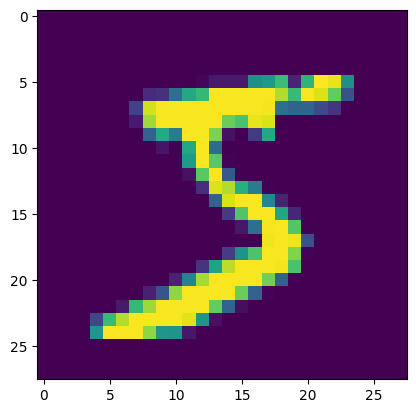

In [4]:
sample_img, sample_label = mnist_tv[0]
print(sample_label)
plt.imshow(sample_img)

Afin de normaliser les pixels de notre jeu de données (en noir et blanc, donc il n'y a qu'un seul canal) nous allons calculer la moyenne et la déviation standard des pixels sur le jeu d'entrainement. On utilise pour cela un `DataLoader` et la fonction `torch.std_mean()` qui calcule la déviation standard et la moyenne du batch.

In [5]:
mnist_tv.transform = transforms.ToTensor()
mnist_tv_loader = DataLoader(mnist_tv, batch_size=32)
mean_color = 0
std_color = 0
for img_tensor, _ in mnist_tv_loader:
  std, mean = torch.std_mean(img_tensor)
  mean_color += mean.item()
  std_color += std.item()
mean_color = mean_color / len(mnist_tv_loader)
std_color = std_color / len(mnist_tv_loader)
print(f"mean = {mean_color}, std = {std_color}")

mean = 0.13066047743558884, std = 0.30746446056365967


Nous allons créer la fonction de transformation des données, avec un redimensionnement, une transformation en tenseur et une normalisation. On modifie ensuite les transformations de nos jeux de données avec ces nouvelles transformations.

In [6]:
mnist_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mean_color,
        std=std_color
    )
])
mnist_tv.transform = mnist_transform
mnist_test.transform = mnist_transform

Nous allons maintenant séparer notre jeu d'entrainement pour avoir un jeu de validation.

In [7]:
valid_ratio = 0.2
valid_size = int(valid_ratio * len(mnist_tv))
train_size = len(mnist_tv) - valid_size
mnist_train, mnist_valid = random_split(mnist_tv, [train_size, valid_size])

On construit les loaders qu'on utilisera plus tard.

In [8]:
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
valid_loader =  DataLoader(mnist_valid, batch_size=32, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=32, shuffle=False)

Il est temps de construire notre modèle qui est une version moderne et améloriée du modèle LeNet5 (http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). Le modèle va être le suivant :

* Un module de convolutions avec :
  * Une convolution (5 x 5) résultant en 6 canaux avec normalisation et activation ReLU.
  * Un MaxPooling (2 x 2) avec un stride de 2.
  * Une convolution (5 x 5) résultant en 16 canaux avec normalisation et activation ReLU.
  * Un MaxPooling (2 x 2) avec un stride de 2.

Le résultat intermédiaire sera donc un tenseur de forme $(batch\_size \times 16 \times final\_width \times final\_width$). La $final\_width$ peut s'obtenir à partir de la taille d'entrée et en calculant séquentiellement la taille des grilles résultantes à chaque étape (voir l'aide de `torch.nn.Conv2d()` et `torch.nn.MaxPool2d()`), ce que nous allons faire automatiquement.

Ensuite on passe les tenseurs (applatis) dans le module suivant.

* Un module pour la classification avec :
  * Une couche entièrement connectée de 120 neurones et activation ReLU et dropout de 30%.
  * Une couche entièrement connectée de 84 neurones et activation ReLU et dropout de 30%.
  * Une couche de sortie avec la nombre de classe.

Le résultat du modèle seront les log-odds pour chaque classe.


In [9]:
class LeNet5(nn.Module):

  # Le constructeur
  def __init__(self, img_width, n_classes):
    super(LeNet5, self).__init__()

    # Le module de convolutions
    self.convolutions = nn.Sequential(
        nn.Conv2d(in_channels=1,
                  out_channels=6,
                  kernel_size=5,
                  stride=1,
                  padding=0),
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2),
        nn.Conv2d(in_channels=6,
                  out_channels=16,
                  kernel_size=5,
                  stride=1,
                  padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    # Calcule automatique des largeurs des grilles
    width_1 = img_width - 4 # Après la première convolution
    width_2 = int((width_1 - 2) / 2 + 1) # Après le premier MaxPool
    width_3 = width_2 - 4 # Après la deuxième convolution
    width_4 = int((width_3 - 2) / 2 + 1) # Après le deuxième MaxPool

    # Le module de classification
    self.classifier = nn.Sequential(
        nn.Linear(in_features=width_4*width_4*16,
                  out_features=120),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(in_features=120,
                  out_features=84),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(in_features=84,
                  out_features=n_classes)

    )

  # La fonction qui fait passer les données dans la modèle
  def forward(self, x):
      y = self.convolutions(x)
      y_flat = y.flatten(1) # On applatit tout au delà de la 1ère dimension
      z = self.classifier(y_flat)
      return z

On crée maintenant une instance du modèle et on l'affiche.

In [10]:
lnet5_model = LeNet5(28, 10)
print(lnet5_model)

LeNet5(
  (convolutions): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=84, out_features=10, bias=True)
  )
)


On peut faire passer une échantillon de notre jeu de données. La sortie ne sera pour le moment pas très intéressante vu que les poids sont pour le moment mis au hasard, mais on s'assure ainsi que notre modèle est bien construit.

In [11]:
sample_tensor, sample_label = mnist_train[0]
sample_tensor = sample_tensor.unsqueeze(0)
print(F.softmax(lnet5_model(sample_tensor), dim=0))
print(sample_label)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<SoftmaxBackward0>)
3


On va créer notre fonction de perte et un optimisateur. On prend ici l'optimisateur `torch.optim.Adam()` (https://arxiv.org/abs/1412.6980) qui est plus sophistiqué et rapide que la descente du gradient simple.

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lnet5_model.parameters(), lr=0.001)

Dans ce TP, nous allons créer un dossier pour stocker des sauvegardes de l'état du modèle après chaque epoch (on appelle cela des checkpoints). Ces sauvegardes ont trois utilités :
  * Si l'entrainement est interrompu avant la fin, il nous est possible de charger la dernière sauvegarde et de reprendre l'entrainement.
  * On peut prendre un modèle qui n'est pas sur-entrainement, et simuler ainsi un arrêt prématuré.
  * On peut reprendre un modèle pour l'entrainer sur d'autres données (fine tuning).

In [13]:
checkpoints_dir = "checkpoints"
os.makedirs(checkpoints_dir, exist_ok=True)

Dans le code suivant, on trouve la boucle d'entrainement. On peut noter l'utilisation de `torch.save()` à la fin de chaque epoch, pour sauvegarder l'état du modèle ainsi que plusieures autres données relatives à l'état. En particulier, on sauvegarde l'état de l'optimisateur, afin de pouvoir reprendre l'entrainement depuis ce point si nécessaire.

Le code tourne relativement lentement. Vous pouvez baisser le nombre d'epochs si vous le désirez.

In [14]:
# Paramètres d'entrainement
n_epochs = 25
# On met le modèle sur le dispositif de calcul
lnet5_model.to(device)

# Pour stocker les pertes d'entrainement et de validations (graphique à suivre)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# La boucle sur les epochs
for epoch in range(n_epochs):

  # Entrainement

  lnet5_model.train()
  train_loss = 0
  train_correct = 0
  for inputs, labels in train_loader:

      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      logit_outputs = lnet5_model(inputs)
      loss = loss_fn(logit_outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_correct += (logit_outputs.argmax(1) == labels).sum().item()

  # Validation

  lnet5_model.eval()
  valid_loss = 0
  valid_correct = 0
  for inputs, labels in valid_loader:

      inputs = inputs.to(device)
      labels = labels.to(device)

      logit_outputs = lnet5_model(inputs)
      loss = loss_fn(logit_outputs, labels)

      valid_loss += loss.item()
      valid_correct += (logit_outputs.argmax(1) == labels).sum().item()

  # ---- Engistrement et affichage

  # Calcul de la perte moyenne et exactitude moyenne
  train_mean_loss = train_loss / len(train_loader.dataset)
  valid_mean_loss = valid_loss / len(valid_loader.dataset)
  train_mean_accuracy = train_correct / len(train_loader.dataset)
  valid_mean_accuracy = valid_correct / len(valid_loader.dataset)

  # Sauvegarde des valeurs
  train_losses.append(train_mean_loss)
  valid_losses.append(valid_mean_loss)
  train_accuracies.append(train_mean_accuracy)
  valid_accuracies.append(valid_mean_accuracy)

  # Sauvegarde du checkpoint
  torch.save({"epoch": epoch + 1,
              "model_state_dict": lnet5_model.state_dict(),
              "optimizer_tat_dict": optimizer.state_dict(),
              "train_loss": train_mean_loss,
              "valid_loss": valid_mean_loss,
              "train_accuracy": train_mean_accuracy,
              "valid_accuracy": valid_mean_accuracy},
             f"{checkpoints_dir}/model_{epoch + 1}.pt")

  # Print
  print(f"Epoch {epoch + 1}/{n_epochs} : "
            f"train loss = {train_mean_loss:.4f}, "
            f"train accuracy = {train_mean_accuracy:.3%}, "
            f"valid loss = {valid_mean_loss:.4f}, "
            f"valid accuracy = {valid_mean_accuracy:.3%}.")

Epoch 1/25 : train loss = 0.0082, train accuracy = 91.963%, valid loss = 0.0024, valid accuracy = 97.833%.
Epoch 2/25 : train loss = 0.0028, train accuracy = 97.348%, valid loss = 0.0018, valid accuracy = 98.375%.
Epoch 3/25 : train loss = 0.0021, train accuracy = 97.956%, valid loss = 0.0014, valid accuracy = 98.642%.
Epoch 4/25 : train loss = 0.0019, train accuracy = 98.275%, valid loss = 0.0014, valid accuracy = 98.683%.
Epoch 5/25 : train loss = 0.0017, train accuracy = 98.510%, valid loss = 0.0015, valid accuracy = 98.742%.
Epoch 6/25 : train loss = 0.0014, train accuracy = 98.621%, valid loss = 0.0016, valid accuracy = 98.475%.
Epoch 7/25 : train loss = 0.0014, train accuracy = 98.785%, valid loss = 0.0013, valid accuracy = 98.783%.
Epoch 8/25 : train loss = 0.0012, train accuracy = 98.831%, valid loss = 0.0011, valid accuracy = 99.000%.
Epoch 9/25 : train loss = 0.0012, train accuracy = 98.906%, valid loss = 0.0011, valid accuracy = 99.033%.
Epoch 10/25 : train loss = 0.0010, tr

On regarde ensuite les graphiques de la perte et de l'exactitude lors de l'entrainement.

[]

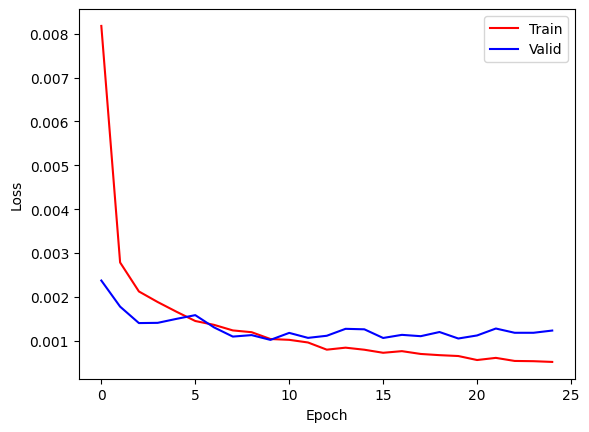

In [15]:
fig, ax = plt.subplots()
ax.plot(train_losses, c="red", label="Train")
ax.plot(valid_losses, c="blue", label="Valid")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.plot()

[]

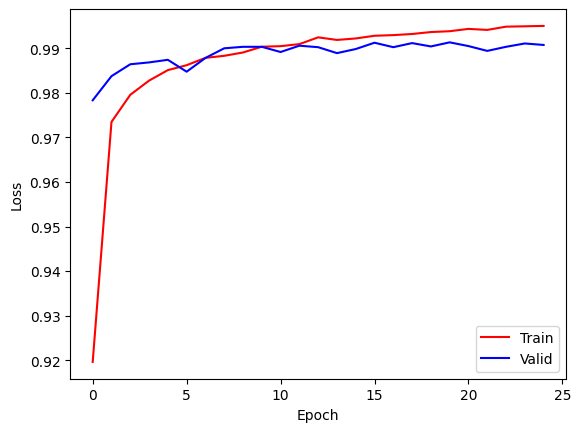

In [16]:
fig, ax = plt.subplots()
ax.plot(train_accuracies, c="red", label="Train")
ax.plot(valid_accuracies, c="blue", label="Valid")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.plot()

On séléctionne maintenant l'epoch qui contient le modèle le plus intéressant. On va charger le modèle de cette epoch. Son erreur de validation est affichée.

In [17]:
best_epoch = np.where(np.array(valid_accuracies) == max(valid_accuracies))[0][0]
best_checkpoint = torch.load(f"{checkpoints_dir}/model_{best_epoch}.pt",
                             weights_only=True)
lnet5_best_model = LeNet5(28, 10)
lnet5_best_model.load_state_dict(best_checkpoint["model_state_dict"])
best_valid_accuracy = best_checkpoint["valid_accuracy"]
print(f"Validation accuracy = {best_valid_accuracy:.4%}")

Validation accuracy = 99.0417%


On va maintenant l'évaluer sur le jeu de test.

In [18]:
lnet5_best_model.eval()
lnet5_best_model.to(device)
test_correct = 0
for inputs, labels in test_loader:
  inputs = inputs.to(device)
  labels = labels.to(device)
  logit_outputs = lnet5_best_model(inputs)
  test_correct += (logit_outputs.argmax(1) == labels).sum().item()

test_accuracy = test_correct / len(test_loader.dataset)
print(f"Test Accuracy = {test_accuracy:.4%}:")

Test Accuracy = 99.0600%:


Le code ci-dessous est tiré de https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca?permalink_comment_id=4008239. Il n'est pas nécessaire d'en comprendre les détails, mais il permet de saisir un chiffre manuscrit (en réalité dessiné avec la souris) directement dans colab et de le sauvegarder dans une image.

In [19]:
canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename, w=320, h=320, line_width=10):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

On lance la fonction et pour dessiner un chiffre.

In [20]:
img_path = "number.png"
draw(img_path)

4421

On va charger notre image en PIL, appliquer nos transformations, retenir que le 4ème canal (on s'intéresse qu'au masque de l'image) et la faire passer (après l'avoir transformée en batch) dans notre modèle. La probabilité des prédicitions pour chaque chiffre s'affiche.

In [21]:
img = PIL.Image.open(img_path)
img_tensor = mnist_transform(img)[3].unsqueeze(0)
img_batch = img_tensor.unsqueeze(0)
logodd = lnet5_best_model(img_batch.to(device))
prob = torch.nn.functional.softmax(logodd, dim=1)[0]
_, indices = torch.sort(prob, descending=True)
for i in indices:
  print(i.item(), f": {prob[i].item():.2%}")

5 : 99.80%
3 : 0.11%
6 : 0.05%
8 : 0.03%
9 : 0.01%
0 : 0.00%
1 : 0.00%
7 : 0.00%
4 : 0.00%
2 : 0.00%


## Exercice : un modèle de classification pour CIFAR10.

Le but est de créer un modèle pour les données CIFAR10 (https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html). Les différents points de l'exercice sont donnés ci-dessous (si possible, travaillez sur le GPU).

1. Commencez par créer des transformations (ce sont presque les mêmes que dans le TP 8). Il y en aura une pour le jeu d'entrainement et une pour le jeu de test.
  Pour le jeu d'entrainement :
    * Un crop aléatoire de (32 x 32) avec padding de 4.
    * Un miroir horizontal aléatoire avec probabilité 0.5.
    * Une transformation en tenseur.
    * Une normalisation avec moyennes = (0.4914, 0.4822, 0.4465) et déviations standards = (0.2023, 0.1994, 0.2010).

  Pour le jeu de test :
    * Transformaiton (resize) de la taille de l'image en 32 x 32.
    * Une transformation en tenseur.
    * Une normalisation avec moyennes = (0.4914, 0.4822, 0.4465) et déviations standards = (0.2023, 0.1994, 0.2010).

2. Chargez les jeux de données d'entrainement et de test CIFAR10 avec `torchvision.datasets.CIFAR10()` en leur appliquant les transformations définies ci-dessus. Vous pouvez les sauvegarder sur votre drive, mais ce n'est pas nécessaire (voir TP 8).

3. Séparez le jeu d'entrainement afin de créer un jeu de validation (20% des données d'entrainement). Changez la transformation du jeu de validation avec la transformation du jeu de test. Créez des DataLoaders pour tous les jeux de données.

4. Créez le modèle suivant :
  * Un module de convolution avec :
    * Une convolution de 3 canaux à 16 canaux avec noyaux (3 x 3), stride de 1, padding de 1, normalisation et activation ReLU.
    * Un MaxPool (2 x 2) avec stride de 2.
    * Une convolution de 16 canaux à 32 canaux avec noyaux (3 x 3), stride de 1, padding de 1, normalisation et activation ReLU.
    * Un MaxPool (2 x 2) avec stride de 2.
    * Une convolution de 32 canaux à 64 canaux avec avec noyaux (3 x 3), stride de 1, padding de 1, normalisation et activation ReLU.
    * Un MaxPool (2 x 2) avec stride de 2.

  * Le résutat intérmédiaire devra être applati. La dimension du tenseur est maintenant de taille (4 x 4 x 64) = 1024, car il n'y a que les couches MaxPool qui ont réduit la taille de la grille (à chaque fois, ils divisent par deux la largeur et hauteur). Ce vecteur applati va entrer dans le module de classification suivant.

  * Module de classification :
    * Une couche entièrement connectée qui prends les 1024 entrées et les amène sur 500 neurones avec activation ReLU et dropout de 0.5.
    * Une couche entièrement connectée qui prends les 500 neurones et qui les amène sur les 10 sorties.

  * La sortie sera en log-odd.

  Instanciez le modèle et passez une image de test pour voir si tout fonctionne bien.

5. Definissez la fonction de perte `torch.nn.CrossEntropyLoss()` et l'optimisateur `torch.optim.Adam()` avec un taux d'apprentissage 0.001.

6. Faites l'entrainement du modèle sur 20 epochs. Sauvegardez l'historique des modèles.

7. Séléctionnez une epoch qui semble minimiser l'erreur de validation, chargez le modèle correspondant, puis évaluez-le sur le jeu de test.

8. Trouvez une image sur internet d'un objet appartenant aux classes CIFAR10, puis appliquez-lui la transformation du jeu de test (vous allez peut-être avoir besoin de changer le mode de l'image PIL avec `img = img.convert("RGB")`). Après l'avoir transformée en tenseur et en batch, passez-la dans votre modèle et regardez la classe la plus probable.